# User Latent Dirichlet Allocation

In [458]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
sys.path.append(os.path.abspath('../../vae_playground'))

In [489]:
%load_ext autoreload
%autoreload 2

from octis.models.LDA import LDA
from octis.dataset.dataset import Dataset as TextDataset

from sklearn.cluster import KMeans

import vae_playground.datasets as datasets

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import Data

In [460]:
DATASET_NAME = 'goi4_dp_small'
RANDOM_SEED = 2112
np.random.seed(RANDOM_SEED)

In [461]:
df = pd.read_csv(f'../data/{DATASET_NAME}/dataset.csv')
data, dates, users = df.iloc[:,:-2].values, df.date.values, df.user.values
date_ids, user_ids = df.date.unique(), df.user.unique()
num_days, num_users = len(date_ids), len(user_ids)
print(f'Loaded {len(data)} consumption profiles from {num_days} dates and {num_users} users')

Loaded 631815 consumption profiles from 365 dates and 1731 users


In [462]:
RESOLUTION = 12 #in hours

if RESOLUTION == 12:
    X = torch.tensor(data, dtype=torch.float32).reshape(-1, 24)
    #circle shift the last dimension of X
    X = torch.cat([X[:,6:], X[:,:6]], dim=-1).reshape(num_users, num_days, int(24/RESOLUTION), int(RESOLUTION)).sum(dim=-1)
else:
    X = torch.tensor(data, dtype=torch.float32).reshape(num_users, num_days, int(24/RESOLUTION), int(RESOLUTION)).sum(dim=-1)
dates, users = np.reshape(dates, (num_users, num_days)), np.reshape(users, (num_users, num_days))

In [463]:
# Remove users with all-zero consumption profiles
nonzero_user_mask = torch.sum(torch.all(X == 0, dim=2), dim=1) < num_days
print(f'Removing {(~nonzero_user_mask).sum()} users with all-zero consumption profiles')
positive_user_mask = torch.sum(torch.any(X < 0, dim=2), dim=1) == 0
print(f'Removing {(~positive_user_mask).sum()} users with any-negative consumption profiles')
user_mask = nonzero_user_mask & positive_user_mask

Removing 4 users with all-zero consumption profiles
Removing 15 users with any-negative consumption profiles


In [464]:
X = X[user_mask]
dates, users = dates[user_mask], users[user_mask]
user_ids = user_ids[user_mask]

In [465]:
USER_SUBSAMPLE_RATE = 5
DAY_SUBSAMPLE_RATE = 10
X = X[::USER_SUBSAMPLE_RATE, ::DAY_SUBSAMPLE_RATE, :]
num_users, num_days, num_features = X.shape
X = X.flatten(end_dim=1)
print(f"Number of (subsampled/filtered) users: {num_users}")
print(f"Number of (subsampled) days: {num_days}")
print(f"Number of (aggregated) features: {num_features}")

Number of (subsampled/filtered) users: 343
Number of (subsampled) days: 365
Number of (aggregated) features: 2


In [466]:
nonzero_mean, nonzero_std = datasets.zero_preserved_log_stats(X)
X_norm = datasets.zero_preserved_log_normalize(X, nonzero_mean, nonzero_std).reshape(num_users, num_days, num_features)
dataset = datasets.UserDayDataset(X_norm)
X_flt = dataset.flatten_inputs
user_idx, day_idx = dataset.user_day_list[:,0], dataset.user_day_list[:,1]

In [467]:
df_plt = pd.DataFrame(torch.cat((X_flt, user_idx.unsqueeze(1), day_idx.unsqueeze(1)), dim=-1))
df_plt.columns = [f'feature_{i}' for i in range(num_features)] + ['user'] + ['day']

In [468]:
if num_users <= 100 and num_features == 2:
    sns.scatterplot(df_plt, x="feature_0", y="feature_1", hue='user', palette="Set1", alpha=.5)
    # move the legend outside
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='user', ncol=5)
    plt.xlabel('Diurnal consumption')
    plt.ylabel('Nocturnal consumption')
    plt.show()

In [469]:
n_bins = 20
kmeans = KMeans(n_clusters=n_bins, random_state=RANDOM_SEED, n_init='auto').fit(X_flt)

In [470]:
labels = kmeans.labels_
labels_onehot = np.zeros((len(labels), len(set(labels))))
labels_onehot[np.arange(len(labels)), labels] = 1
X_words = torch.tensor(labels_onehot).reshape(num_users, num_days, -1)

In [471]:
DOC_TYPE = "day"       # "day" or "user"

if DOC_TYPE == "day":
    X_document = X_words.sum(dim=0)
elif DOC_TYPE == "user":
    X_document = X_words.sum(dim=1)
else:
    raise ValueError(f"Invalid DOC_TYPE: {DOC_TYPE}")

num_docs, num_words = X_document.shape

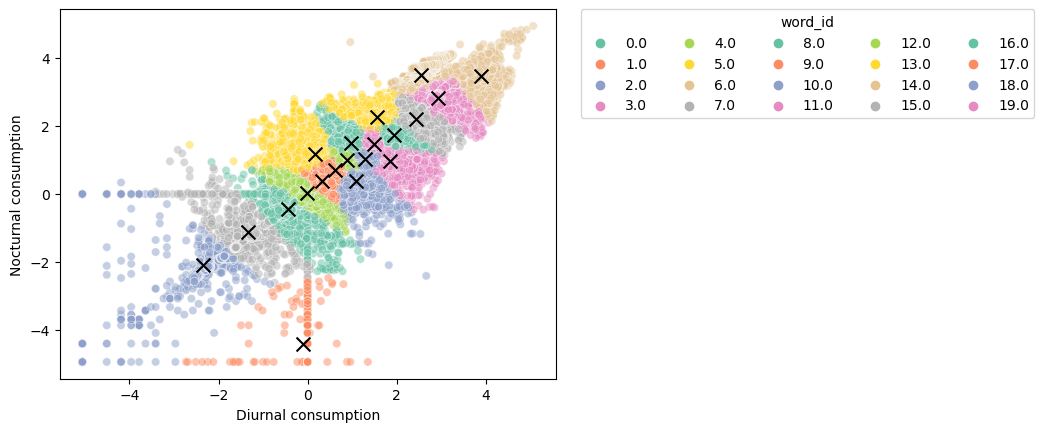

In [472]:
if n_bins <= 50 and num_features == 2:
    df_plt = pd.DataFrame(torch.cat((X_flt,torch.tensor(labels).unsqueeze(1)), dim=-1))
    df_plt.columns = [f'feature_{i}' for i in range(num_features)] + ['word']
    sns.scatterplot(df_plt, x="feature_0", y="feature_1", hue='word', palette="Set2", alpha=.5)
    plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker='x', s=100, c='black')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='word_id', ncol=5)
    plt.xlabel('Diurnal consumption')
    plt.ylabel('Nocturnal consumption')
    plt.show()

In [473]:
X_labels = torch.tensor(labels).reshape(num_users, num_days)
if DOC_TYPE == "day": X_labels = X_labels.T

In [474]:
TEST_RATIO = 0.0
VAL_RATIO = 0.0

In [475]:
X_partition = ["train"]*num_docs
X_partition[:int(num_docs*VAL_RATIO)] = ["val"]*int(num_docs*VAL_RATIO)
X_partition[int(num_docs*(1-TEST_RATIO))+1:] = ["test"]*int(num_docs*TEST_RATIO)
#randomly shuffle the partition
np.random.shuffle(X_partition)

In [476]:
# Create the directory if it doesn't exist
directory = f"../corpuses/{DATASET_NAME}"
os.makedirs(directory, exist_ok=True)

# Write the tsv file
tsv_file = open(f"{directory}/corpus.tsv", "w")
for i in range(len(X_labels)):
    tsv_file.write(' '.join([str(j.item()) for j in X_labels[i]]) + "\t" + str(X_partition[i]) + "\n")
tsv_file.close()

# Write the vocab file
vocabulary = [str(i) for i in range(n_bins)]
vocabulary_file = open(f"{directory}/vocabulary.txt", "w")
for i in range(len(vocabulary)): vocabulary_file.write(vocabulary[i] + "\n")
vocabulary_file.close()

In [477]:
lda_dataset = TextDataset()
lda_dataset.load_custom_dataset_from_folder(f"{directory}")

In [478]:
# Set training parameters.
num_topics = 10
chunksize = 2000
passes = 100
iterations = 400
eval_every = 100  # Don't evaluate model perplexity, takes too much time.

In [492]:
model = LDA(chunksize=chunksize,
            alpha="auto",
            eta="auto",
            iterations=iterations,
            num_topics=num_topics,
            passes=passes,
            eval_every=eval_every,
            random_state=0,)

TypeError: __init__() got an unexpected keyword argument 'corpus'

In [480]:
# Train the model using default partitioning choice 
output = model.train_model(lda_dataset, partitioned=True)

topic-word-matrix
topics
topic-document-matrix
test-topic-document-matrix


In [490]:
from octis.evaluation_metrics.diversity_metrics import TopicDiversity as diversity_metric
from octis.evaluation_metrics.coherence_metrics import Coherence as coherence_metric
# from octis.evaluation_metrics.classification_metrics import F1Score as classification_metric
# from octis.evaluation_metrics.similarity_metrics import RBO as similarity_metric
# from octis.evaluation_metrics.significance_metrics import KL_uniform as significance_metric

# Initialize the coherence metric
npmi = coherence_metric(texts=lda_dataset.get_corpus(), topk=10, measure='c_npmi')
# Initialize diversity metric
topic_diversity = diversity_metric(topk=10)

In [491]:
# Retrieve metrics score
topic_diversity_score = topic_diversity.score(output)
print("Topic diversity: "+str(topic_diversity_score))

npmi_score = npmi.score(output)
print("Coherence: "+str(npmi_score))

Topic diversity: 0.17
Coherence: -0.033275639852397135


In [483]:
word_topics = torch.tensor(output["topic-word-matrix"])

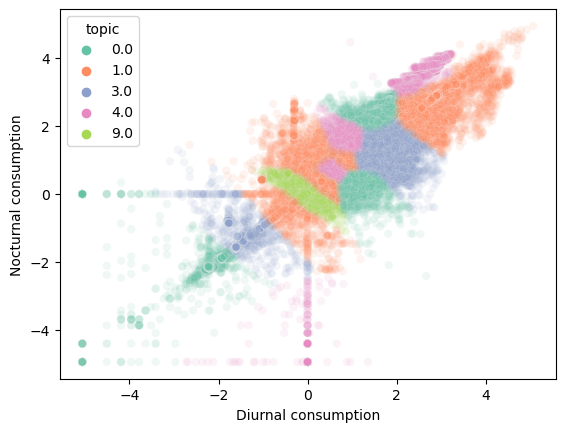

In [484]:
if num_topics<50 and num_features == 2:
    df_plt = pd.DataFrame(torch.cat((X_flt,(X_words.flatten(end_dim=1)@(word_topics.max(dim=0)[1].numpy())).unsqueeze(1)), dim=-1))
    df_plt.columns = [f'feature_{i}' for i in range(num_features)] + ['topic']
    sns.scatterplot(df_plt, x="feature_0", y="feature_1", hue='topic', palette="Set2", alpha=.1)
    plt.xlabel('Diurnal consumption')
    plt.ylabel('Nocturnal consumption')
    plt.show()

In [485]:
gamma_document = torch.tensor(output["topic-document-matrix"])

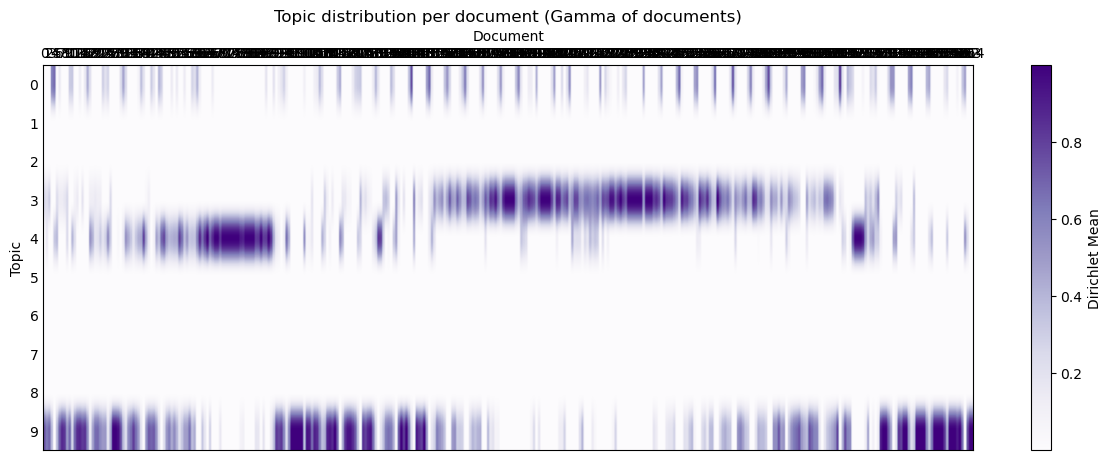

In [486]:
fig, ax = plt.subplots(figsize=(15,5))
im = ax.imshow(gamma_document, aspect='auto', cmap='Purples')
ax.set_title('Topic distribution per document (Gamma of documents)')
ax.set_ylabel('Topic')
ax.set_xlabel('Document')
ax.set_yticks(np.arange(num_topics))
ax.set_xticks(np.arange(num_docs))
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
fig.colorbar(im, ax=ax, label='Dirichlet Mean')
plt.show()

In [487]:
word_topics = torch.tensor(output["topic-word-matrix"])

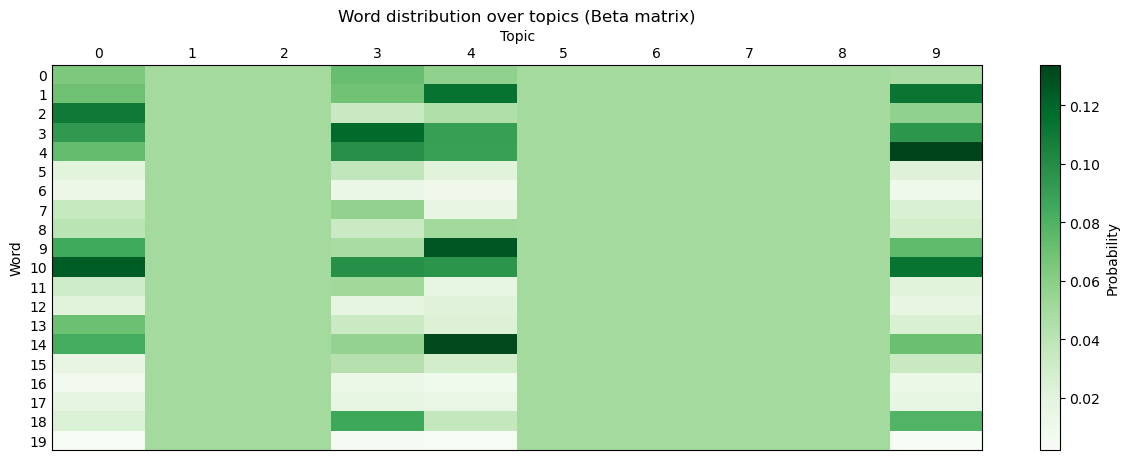

In [488]:
fig, ax = plt.subplots(figsize=(15,5))
im = ax.imshow(word_topics.T, aspect='auto', cmap='Greens')
ax.set_title('Word distribution over topics (Beta matrix)')
ax.set_xlabel('Topic')
ax.set_ylabel('Word')
ax.set_xticks(np.arange(num_topics))
ax.set_yticks(np.arange(n_bins))
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
fig.colorbar(im, ax=ax, label='Probability')
plt.show()